# Fraud Detection Using Isolation Forests

In this notebook, I will use [Isolation Forests](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html) for anomaly detection.

Isolation forests ‘isolate’ observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature. Since recursive partitioning can be represented by a tree structure, the number of splittings required to isolate a sample is equivalent to the path length from the root node to the terminating node. This path length, averaged over a forest of such random trees, is a measure of normality and our decision function.

The dataset used is in this notebook is: url:https://www.kaggle.com/ealaxi/paysim1.

I will use the databricks classroom-setup to load the dataset.

### Objectives:
* Build an isolation forest to identify fraud 
* Compare with true labels(The dataset has true labels)

In [0]:
%run "../Includes/Classroom-Setup"

In [0]:
import pandas as pd
import numpy as np
filePath = "dbfs:/mnt/training/fraud/paysim-fraud-detection.csv"
df = spark.read.csv(filePath, inferSchema=True, header=True).toPandas()
df.head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0,0
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0,0
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0,0
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,0
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0,0
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0,0


Initialized classroom variables & functions...

## Feature engineering
* The dataframe has the column 'isFraud' that I will use to choose the contamination hyperparameter.
* In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.(Kaggle information)

In [0]:
#See if the dataframe has any null values
df.isnull().sum()

Out[143]: step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [0]:
#Fraud only occurs in cash_out and transfer
df1=df.loc[(df['type']=='CASH_OUT') | (df['type']=='TRANSFER')]
df1.head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.00,C1305486145,181.00,0.0,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.0,C38997010,21182.0,0.00,1,0
15,1,CASH_OUT,229133.94,C905080434,15325.00,0.0,C476402209,5083.0,51513.44,0,0
19,1,TRANSFER,215310.30,C1670993182,705.00,0.0,C1100439041,22425.0,0.00,0,0
24,1,TRANSFER,311685.89,C1984094095,10835.00,0.0,C932583850,6267.0,2719172.89,0,0
42,1,CASH_OUT,110414.71,C768216420,26845.41,0.0,C1509514333,288800.0,2415.16,0,0
47,1,CASH_OUT,56953.90,C1570470538,1942.02,0.0,C824009085,70253.0,64106.18,0,0
48,1,CASH_OUT,5346.89,C512549200,0.00,0.0,C248609774,652637.0,6453430.91,0,0
51,1,CASH_OUT,23261.30,C2072313080,20411.53,0.0,C2001112025,25742.0,0.00,0,0
58,1,TRANSFER,62610.80,C1976401987,79114.00,16503.2,C1937962514,517.0,8383.29,0,0


In [0]:
#Find the contamination hyperparameter, normally the manager has a prediction number based on previous analysis
df1['isFraud'].value_counts()

Out[145]: 0    2762196
1       8213
Name: isFraud, dtype: int64

In [0]:
#I will use the contamination value been c=8213/(2762196+8213)=0.002964544224336551
#Let's drop the label columns
df1.drop(['isFraud','isFlaggedFraud'],axis=1,inplace=True)
df1.head(10)

/databricks/python/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest
2,1,TRANSFER,181.00,C1305486145,181.00,0.0,C553264065,0.0,0.00
3,1,CASH_OUT,181.00,C840083671,181.00,0.0,C38997010,21182.0,0.00
15,1,CASH_OUT,229133.94,C905080434,15325.00,0.0,C476402209,5083.0,51513.44
19,1,TRANSFER,215310.30,C1670993182,705.00,0.0,C1100439041,22425.0,0.00
24,1,TRANSFER,311685.89,C1984094095,10835.00,0.0,C932583850,6267.0,2719172.89
42,1,CASH_OUT,110414.71,C768216420,26845.41,0.0,C1509514333,288800.0,2415.16
47,1,CASH_OUT,56953.90,C1570470538,1942.02,0.0,C824009085,70253.0,64106.18
48,1,CASH_OUT,5346.89,C512549200,0.00,0.0,C248609774,652637.0,6453430.91
51,1,CASH_OUT,23261.30,C2072313080,20411.53,0.0,C2001112025,25742.0,0.00
58,1,TRANSFER,62610.80,C1976401987,79114.00,16503.2,C1937962514,517.0,8383.29


*Create a column that shows the error of the origin balance.
1. Positive values show that the user transfered more than he or she has.

*Create a column that shows the error of the destination balance.
2. Positive values show that the difference in user's account destination is less than the amount in transaction.
2. Negative values show that the difference in user's account destination is greater than the amount in transaction.

In [0]:
error_origin=round(df1['amount']-(df1['oldbalanceOrg']-df1['newbalanceOrig']),1)
error_dest=round(df1['amount']-abs(df1['newbalanceDest']-df1['oldbalanceDest']),1)
df1.insert(6,'error_origin',error_origin)
df1['error_dest']=error_dest
df1.head(20)

<command-2023619662775729>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['error_dest']=error_dest


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,error_origin,nameDest,oldbalanceDest,newbalanceDest,error_dest
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,0.0,C553264065,0.00,0.00,181.0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,0.0,C38997010,21182.00,0.00,-21001.0
15,1,CASH_OUT,229133.94,C905080434,15325.00,0.00,213808.9,C476402209,5083.00,51513.44,182703.5
19,1,TRANSFER,215310.30,C1670993182,705.00,0.00,214605.3,C1100439041,22425.00,0.00,192885.3
24,1,TRANSFER,311685.89,C1984094095,10835.00,0.00,300850.9,C932583850,6267.00,2719172.89,-2401220.0
42,1,CASH_OUT,110414.71,C768216420,26845.41,0.00,83569.3,C1509514333,288800.00,2415.16,-175970.1
47,1,CASH_OUT,56953.90,C1570470538,1942.02,0.00,55011.9,C824009085,70253.00,64106.18,50807.1
48,1,CASH_OUT,5346.89,C512549200,0.00,0.00,5346.9,C248609774,652637.00,6453430.91,-5795447.0
51,1,CASH_OUT,23261.30,C2072313080,20411.53,0.00,2849.8,C2001112025,25742.00,0.00,-2480.7
58,1,TRANSFER,62610.80,C1976401987,79114.00,16503.20,0.0,C1937962514,517.00,8383.29,54744.5


In [0]:
df1.dtypes

Out[148]: step                int32
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
error_origin      float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
error_dest        float64
dtype: object

In [0]:
#Let's build the feature vector 'X'
X=df1.select_dtypes(exclude='object')
X.head(20)

,step,amount,oldbalanceOrg,newbalanceOrig,error_origin,oldbalanceDest,newbalanceDest,error_dest
2,1,181.00,181.00,0.00,0.0,0.00,0.00,181.0
3,1,181.00,181.00,0.00,0.0,21182.00,0.00,-21001.0
15,1,229133.94,15325.00,0.00,213808.9,5083.00,51513.44,182703.5
19,1,215310.30,705.00,0.00,214605.3,22425.00,0.00,192885.3
24,1,311685.89,10835.00,0.00,300850.9,6267.00,2719172.89,-2401220.0
42,1,110414.71,26845.41,0.00,83569.3,288800.00,2415.16,-175970.1
47,1,56953.90,1942.02,0.00,55011.9,70253.00,64106.18,50807.1
48,1,5346.89,0.00,0.00,5346.9,652637.00,6453430.91,-5795447.0
51,1,23261.30,20411.53,0.00,2849.8,25742.00,0.00,-2480.7
58,1,62610.80,79114.00,16503.20,0.0,517.00,8383.29,54744.5


In [0]:
#Build the model
from sklearn.ensemble import IsolationForest

isolation_forest = IsolationForest(n_estimators=80,contamination=0.003, n_jobs=-1, max_samples=512, random_state=42)
y_predict = isolation_forest.fit_predict(X)

In [0]:
#Let's transform the predicted value -1 to 1(fraud classification) and 1 to 0 (not fraud)
y_predict=pd.Series(y_predict,index=X.index).apply(lambda x: 1 if x==-1 else 0)
y_true=df['isFraud'].loc[X.index]
y_true_prediction=pd.concat([y_predict,y_true],axis=1)

In [0]:
y_predict.value_counts()

Out[152]: 0    2762098
1       8311
dtype: int64

In [0]:
y_true.value_counts()


Out[153]: 0    2762196
1       8213
Name: isFraud, dtype: int64

In [0]:
#See how many predictions are correct
y_true_prediction[(y_true_prediction[0]==1) & (y_true_prediction['isFraud']==1)]

,0,isFraud
4440,1,1
4441,1,1
4443,1,1
10395,1,1
10396,1,1
...,...,...
6362583,1,1
6362584,1,1
6362598,1,1
6362616,1,1


* Only 881 labels was correct classified.
* The dataframe is unbalanced, so I will use 'precision' and 'AUC' score to evaluate the model, because I want to reduce the number of false positive to not cause trouble to the clients.

In [0]:
#Evaluate the model
from sklearn.metrics import precision_score,roc_auc_score
print(precision_score(y_true,y_predict),roc_auc_score(y_true,y_predict))

0.10600409096378294 0.5522895375340791


1. The model is able to predict only 11% of the frauds.
1. I will use PCA algorithm to transform the data in 2d and plot the outliers.

In [0]:
#Make the transformations
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaler.fit(X)
X1=scaler.transform(X)
pca_2=PCA(2)
pca_2.fit(X1)
X_pca_2=pca_2.transform(X1)

In [0]:
#Show the variance of PCA1 and PCA2
pca_2.explained_variance_ratio_.sum()

Out[157]: 0.5857952777310674

No handles with labels found to put in legend.


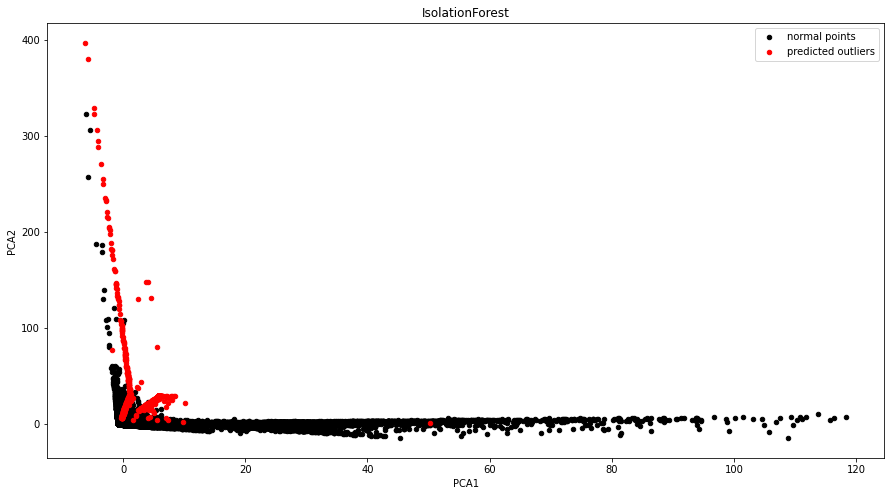

In [0]:
#Transform 'X_pca' in a dataframe and plot the outliers predicted columns from the IsolationForest
import matplotlib.pyplot as plt
X_pca_2_df=pd.DataFrame(X_pca_2,index=y_true_prediction.index)
#Store the index of normal points and true outliers predicted
true_normal_index=y_true_prediction[y_true_prediction['isFraud']!=1].index
predicted_outliers_index=y_true_prediction[(y_true_prediction[0]==1) & (y_true_prediction['isFraud']==1)].index

plt.figure(figsize=(15,8))
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.title("IsolationForest")
plt.legend(loc="upper right")
a=plt.scatter(X_pca_2_df.loc[true_normal_index][0],X_pca_2_df.loc[true_normal_index][1], c='black', s=20)
b=plt.scatter(X_pca_2_df.loc[predicted_outliers_index][0],X_pca_2_df.loc[predicted_outliers_index][1], c='red', s=20)
plt.legend([a, b], ["normal points","predicted outliers"])
plt.show()

### Now I will plot a 3 d graph using 3 components in PCA

In [0]:
pca_3=PCA(3)
pca_3.fit(X1)
X_pca_3=pca_3.transform(X1)
pca_3.explained_variance_ratio_.sum()

Out[159]: 0.7380832943299079

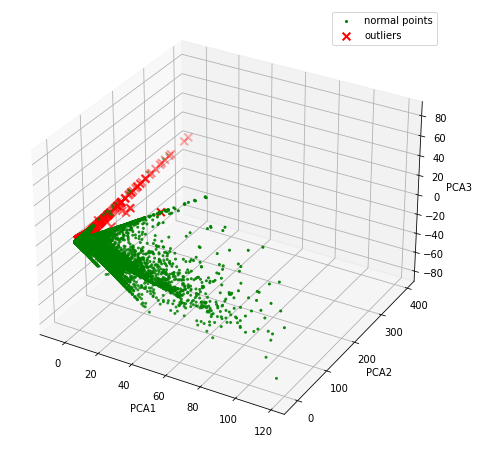

Datasets are already mounted to /mnt/training from s3a://databricks-corp-training/common

Declared various utility methods: 
 Declared untilStreamIsReady( name:String ) to control workflow 
 
 All done!

In [0]:
from mpl_toolkits.mplot3d import Axes3D
X_pca_3_df=pd.DataFrame(X_pca_3,index=y_true_prediction.index)


#3d graph
fig=plt.figure(figsize=(15,8))
ax = fig.add_subplot(111, projection='3d')

ax.set_xlabel("PCA1")
ax.set_ylabel("PCA2")
ax.set_zlabel("PCA3")

# Plot the compressed data points
ax.scatter(X_pca_3_df.loc[true_normal_index][0], X_pca_3_df.loc[true_normal_index][1],X_pca_3_df.loc[true_normal_index][2], s=4, lw=1, label="normal points",c="green")
# Plot x's for the ground truth outliers
ax.scatter(X_pca_3_df.loc[predicted_outliers_index][0], X_pca_3_df.loc[predicted_outliers_index][1],X_pca_3_df.loc[predicted_outliers_index][2],
           lw=2, s=60, marker="x", c="red", label="outliers")
ax.legend()
plt.show()


### The algorithm was able to predict only 11% of fraud, therefore it's really difficult to predict fraud without true labels.